Practical Efficiency with Losses: 25.69%


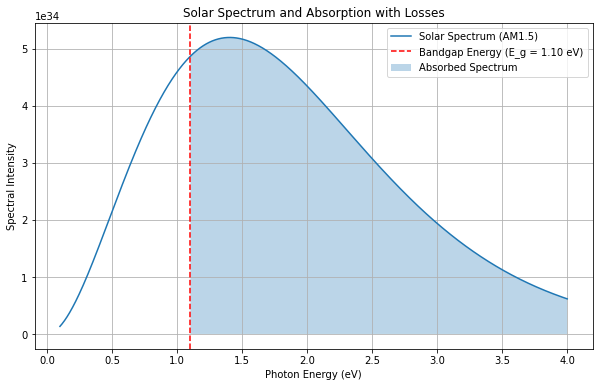

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, c, k

# Constants
q = 1.602e-19  # Elementary charge (C)
hc = h * c  # Planck's constant times the speed of light (J*m)
T_sun = 5778  # Sun's temperature (K)
kT_sun = k * T_sun

# Reasonable Loss Parameters
reflection_loss = 0.1  # 10% of sunlight is reflected
recombination_loss = 0.2  # 20% of generated carriers are lost
resistive_loss = 0.05  # 5% of power is lost due to resistance
thermalization_efficiency = 0.8  # 80% efficiency for photons above bandgap

# Functions
def solar_spectrum(E_photon):
    """
    Calculate the solar spectrum (AM1.5) as a function of photon energy.
    """
    spectrum = (2 * np.pi * c**2 * E_photon**3) / ((hc)**3 * (np.exp(E_photon / kT_sun) - 1))
    return spectrum

def calculate_efficiency(E_g, E_photon, spectrum):
    """
    Calculate the practical efficiency of a solar cell considering various losses.
    """
    absorbed = E_photon >= E_g
    absorbed_spectrum = spectrum[absorbed]
    absorbed_energy = E_photon[absorbed]
    
    # Include thermalization efficiency
    effective_energy = np.minimum(absorbed_energy, E_g) * thermalization_efficiency
    
    # Calculate generated power considering losses
    power_generated = np.trapz(effective_energy * absorbed_spectrum, x=E_photon[absorbed])
    
    # Apply reflection, recombination, and resistive losses
    power_generated *= (1 - reflection_loss) * (1 - recombination_loss) * (1 - resistive_loss)

    total_power = np.trapz(E_photon * spectrum, x=E_photon)
    
    efficiency = power_generated / total_power
    return efficiency

# Parameters
E_photon = np.linspace(0.1, 4, 1000) * q  # Photon energy range in Joules
spectrum = solar_spectrum(E_photon)
E_g = 1.1 * q  # Bandgap energy for silicon in Joules

# Calculate efficiency
efficiency = calculate_efficiency(E_g, E_photon, spectrum)
print(f"Practical Efficiency with Losses: {efficiency * 100:.2f}%")

# Plot the solar spectrum and absorption
plt.figure(figsize=(10, 6))
plt.plot(E_photon / q, spectrum, label="Solar Spectrum (AM1.5)")
plt.axvline(E_g / q, color="r", linestyle="--", label=f"Bandgap Energy (E_g = {E_g / q:.2f} eV)")
plt.fill_between(E_photon / q, spectrum, where=(E_photon >= E_g), alpha=0.3, label="Absorbed Spectrum")
plt.title("Solar Spectrum and Absorption with Losses")
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Spectral Intensity")
plt.legend()
plt.grid()
plt.show()


Ideal Efficiency: 44.81%
Practical Efficiency: 27.42%


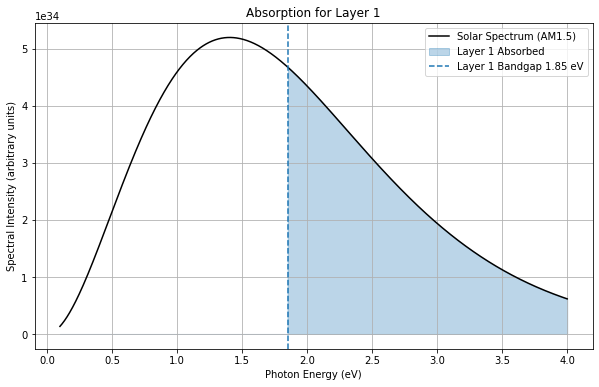

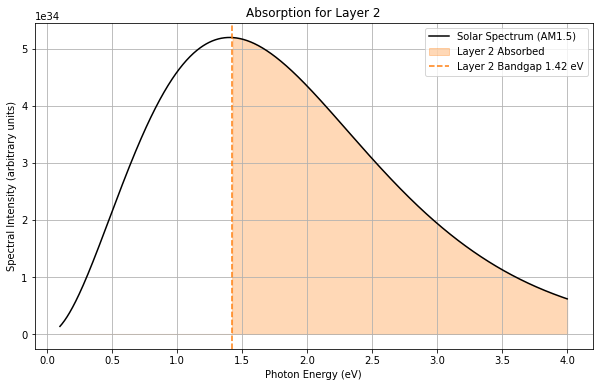

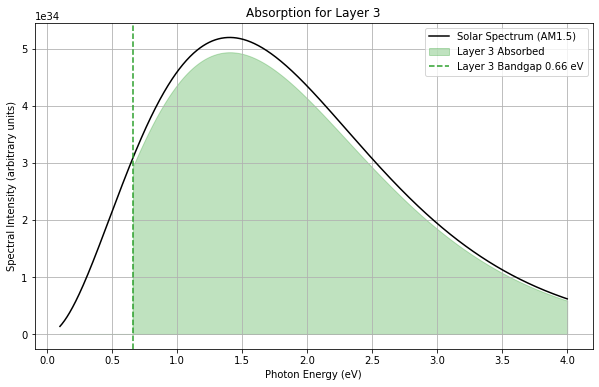

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, c, k

# Constants
q = 1.602e-19  # Elementary charge (C)
hc = h * c  # Planck's constant times the speed of light (J*m)

# Solar spectrum (AM1.5)
def solar_spectrum(E_photon):
    T_sun = 5778  # Sun's temperature (K)
    kT_sun = k * T_sun
    spectrum = (2 * np.pi * c**2 * E_photon**3) / ((hc)**3 * (np.exp(E_photon / kT_sun) - 1))
    return spectrum

# Absorption calculation
def absorption(alpha, d, E_photon):
    return 1 - np.exp(-alpha * d)

# Layer-by-layer absorption and power contribution
def layer_efficiency(E_g, alpha, d, E_photon, transmitted_spectrum):
    absorbed = absorption(alpha, d, E_photon)
    usable_photons = (E_photon >= E_g)
    effective_energy = np.minimum(E_photon, E_g) * absorbed * usable_photons
    layer_power = np.trapz(effective_energy * transmitted_spectrum, x=E_photon)
    
    # Reduce transmitted spectrum for subsequent layers
    remaining_spectrum = transmitted_spectrum * (1 - absorbed)
    return layer_power, remaining_spectrum

# Total efficiency function
def total_efficiency(layers, E_photon, spectrum):
    transmitted_spectrum = spectrum  # Start with full spectrum
    total_power = 0
    incident_power = np.trapz(E_photon * spectrum, x=E_photon)  # Total incident power
    for layer in layers:
        E_g, alpha, d = layer
        layer_power, transmitted_spectrum = layer_efficiency(E_g, alpha, d, E_photon, transmitted_spectrum)
        total_power += layer_power
    return total_power / incident_power

# Efficiency with loss mechanisms
def practical_efficiency(layers, E_photon, spectrum, losses):
    transmitted_spectrum = spectrum  # Start with full spectrum
    total_power = 0
    incident_power = np.trapz(E_photon * spectrum, x=E_photon)  # Total incident power
    for layer in layers:
        E_g, alpha, d = layer
        layer_power, transmitted_spectrum = layer_efficiency(E_g, alpha, d, E_photon, transmitted_spectrum)
        
        # Apply loss mechanisms
        layer_power *= (1 - losses['reflection']) * (1 - losses['thermalization']) * (1 - losses['recombination'])
        total_power += layer_power
    return total_power / incident_power

# Material and layer properties
layers = [
    # Example: [Bandgap (J), Absorption coefficient (1/m), Thickness (m)]
    [1.85 * q, 1e7, 1e-6],  # Layer 1: GaInP2
    [1.424 * q, 1e7, 2e-6],  # Layer 2: GaAs
    [0.66 * q, 1e6, 3e-6],  # Layer 3: Ge
]

# Photon energy range (in Joules)
E_photon = np.linspace(0.1, 4, 1000) * q
spectrum = solar_spectrum(E_photon)

# Ideal efficiency
ideal_efficiency = total_efficiency(layers, E_photon, spectrum)
print(f"Ideal Efficiency: {ideal_efficiency * 100:.2f}%")

# Loss mechanisms
losses = {
    'reflection': 0.1,  # 10% reflection loss
    'thermalization': 0.2,  # 20% thermalization loss
    'recombination': 0.15,  # 15% recombination loss
}

# Practical efficiency
practical_efficiency_value = practical_efficiency(layers, E_photon, spectrum, losses)
print(f"Practical Efficiency: {practical_efficiency_value * 100:.2f}%")

# Plot individual graphs for each layer
for i, layer in enumerate(layers):
    E_g, alpha, d = layer
    absorption_curve = absorption(alpha, d, E_photon)
    absorbed_spectrum = absorption_curve * spectrum
    
    # Shade only the portion above the bandgap
    mask = E_photon >= E_g
    absorbed_spectrum_above_bandgap = absorbed_spectrum * mask

    plt.figure(figsize=(10, 6))
    plt.plot(E_photon / q, spectrum, label="Solar Spectrum (AM1.5)", color="black")
    plt.fill_between(E_photon / q, absorbed_spectrum_above_bandgap, color=f"C{i}", alpha=0.3, label=f"Layer {i+1} Absorbed")
    plt.axvline(E_g / q, color=f"C{i}", linestyle="--", label=f"Layer {i+1} Bandgap {E_g / q:.2f} eV")

    plt.title(f"Absorption for Layer {i+1}")
    plt.xlabel("Photon Energy (eV)")
    plt.ylabel("Spectral Intensity (arbitrary units)")
    plt.legend()
    plt.grid()
    plt.show()
